# Financial Market Data Exploratory Data Analysis

This notebook performs exploratory data analysis on financial market data across multiple asset classes:
- Stocks (AAPL, MSFT, AMZN, GOOGL, TSLA)
- ETFs and Market Indices
- Bonds and Commodities
- Cryptocurrencies
- Economic Indicators

In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plot settings
%matplotlib inline
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2, palette="deep")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

## Data Loading and Preprocessing

Loading data from multiple sources:
- Yahoo Finance data for stocks, ETFs, indices
- Cryptocurrency historical data
- FRED economic indicators

In [12]:
# Define asset lists
stocks = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA']
etfs = ['SPY', 'QQQ', 'XLK', 'XLV', 'XLF']
indices = ['^GSPC', '^IXIC', '^DJI', '^RUT']
bonds = ['^TNX', 'IEF', 'TLT']
commodities = ['GC=F', 'CL=F', 'SI=F']
reits = ['VNQ', 'SCHH', 'IYR']
cryptos = ['BTC', 'ETH', 'LTC']
economic_indicators = {
    'CPI': 'CPIAUCSL',
    'FEDFUNDS': 'FEDFUNDS',
    'UNRATE': 'UNRATE',
    'PPI': 'PPIACO'
}

# Load merged data
merged_data = pd.read_csv('data/processed/merged_data.csv')
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

## Price Analysis Functions

Functions to analyze and visualize price movements across different asset classes:
- Price trends over time
- Moving averages
- Volume analysis
- Correlation studies

In [13]:
def plot_prices_over_time(assets, title, data=merged_data):
    plt.figure(figsize=(14, 7))
    for asset in assets:
        col = f"{asset}_Close"  # Remove the economic indicators check
        if col in data.columns:
            plt.plot(data['Date'], data[col], label=asset.replace('=F', '').replace('^', ''))
    
    plt.title(f'{title} Prices Over Time')
    plt.xlabel('Year')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_annual_average(assets, title, data=merged_data):
    plt.figure(figsize=(14, 7))
    for asset in assets:
        col = f"{asset}_Close"
        if col in data.columns:
            annual_avg = data.groupby(data['Date'].dt.year)[col].mean()
            plt.plot(annual_avg.index, annual_avg.values, marker='o', 
                    label=asset.replace('=F', '').replace('^', ''))
    
    plt.title(f'Average Annual {title} Prices')
    plt.xlabel('Year')
    plt.ylabel('Average Price (USD)')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [14]:
def plot_economic_indicators(data=merged_data):
    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot GDP separately
    ax1.plot(data['Date'], data['GDP'], label='GDP', color='darkblue')
    ax1.set_title('Gross Domestic Product (GDP)')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Billions of USD')
    ax1.legend()
    ax1.grid(True)
    
    # Plot other indicators
    other_indicators = ['CPI', 'FEDFUNDS', 'UNRATE', 'PPI']
    for indicator in other_indicators:
        ax2.plot(data['Date'], data[indicator], label=indicator)
    
    ax2.set_title('Other Economic Indicators')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Value')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

## Correlation Analysis

Analyzing relationships between different assets:
- Cross-asset correlations
- Heatmap visualizations
- Temporal correlation patterns

In [15]:
def plot_price_correlations(assets, title, data=merged_data):
    cols = [f"{asset}_Close" for asset in assets]
    cols = [col for col in cols if col in data.columns]
    
    correlation = data[cols].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Matrix of {title} Prices')
    plt.tight_layout()
    plt.show()

## Technical Analysis

Implementing common technical analysis tools:
- Moving averages
- Volume analysis
- Trend indicators

In [16]:
def plot_moving_averages(window=50, data=merged_data):
    plt.figure(figsize=(14, 7))
    for stock in stocks:
        col = f"{stock}_Close"
        if col in data.columns:
            data[f'{stock}_MA'] = data[col].rolling(window=window).mean()
            plt.plot(data['Date'], data[col], label=f"{stock} Close")
            plt.plot(data['Date'], data[f'{stock}_MA'], label=f"{stock} {window}-Day MA")
    
    plt.title(f'{window}-Day Moving Averages for Stocks')
    plt.xlabel('Year')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.tight_layout()
    plt.show()

## Volatility Analysis
Analyzing price volatility across different asset classes using:
- Rolling standard deviation
- Daily returns distribution
- Volatility clustering

In [17]:
def plot_volatility_analysis(assets, title, window=30, data=merged_data):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
    
    # Rolling Volatility
    for asset in assets:
        col = f"{asset}_Close"
        if col in data.columns:
            # Calculate daily returns
            returns = data[col].pct_change()
            # Calculate rolling volatility
            volatility = returns.rolling(window=window).std() * np.sqrt(252)  # Annualized
            ax1.plot(data['Date'], volatility, label=asset)
    
    ax1.set_title(f'{window}-Day Rolling Volatility ({title})')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Annualized Volatility')
    ax1.legend()
    ax1.grid(True)
    
    # Returns Distribution
    for asset in assets:
        col = f"{asset}_Close"
        if col in data.columns:
            returns = data[col].pct_change().dropna()
            sns.kdeplot(data=returns, label=asset, ax=ax2)
    
    ax2.set_title(f'Returns Distribution ({title})')
    ax2.set_xlabel('Daily Returns')
    ax2.set_ylabel('Density')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

## Market Performance Comparison
Comparing performance across different market segments:
- Cumulative returns
- Drawdown analysis
- Risk-adjusted returns

In [18]:
def plot_cumulative_returns(assets, title, data=merged_data):
    plt.figure(figsize=(14, 7))
    
    for asset in assets:
        col = f"{asset}_Close"
        if col in data.columns:
            # Calculate cumulative returns
            returns = data[col].pct_change()
            cum_returns = (1 + returns).cumprod()
            plt.plot(data['Date'], cum_returns, label=asset)
    
    plt.title(f'Cumulative Returns ({title})')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_drawdown_analysis(assets, title, data=merged_data):
    plt.figure(figsize=(14, 7))
    
    for asset in assets:
        col = f"{asset}_Close"
        if col in data.columns:
            # Calculate drawdown
            price_series = data[col]
            rolling_max = price_series.cummax()
            drawdown = (price_series - rolling_max) / rolling_max
            plt.plot(data['Date'], drawdown, label=asset)
    
    plt.title(f'Drawdown Analysis ({title})')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Market Rotation Analysis
Analyzing relative performance and rotation between:
- Different market sectors
- Risk-on vs Risk-off assets
- Traditional vs Digital assets

In [19]:
def plot_relative_strength(base_asset, compare_assets, window=90, data=merged_data):
    plt.figure(figsize=(14, 7))
    
    base_col = f"{base_asset}_Close"
    base_price = data[base_col]
    
    for asset in compare_assets:
        col = f"{asset}_Close"
        if col in data.columns:
            # Calculate relative strength
            relative_strength = data[col] / base_price
            # Normalize to starting point
            relative_strength = relative_strength / relative_strength.iloc[0]
            # Apply smoothing
            smooth_rs = relative_strength.rolling(window=window).mean()
            plt.plot(data['Date'], smooth_rs, label=f'{asset} vs {base_asset}')
    
    plt.title(f'Relative Strength Analysis (vs {base_asset})')
    plt.xlabel('Date')
    plt.ylabel('Relative Strength')
    plt.legend()
    plt.grid(True)
    plt.axhline(y=1, color='black', linestyle='--')
    plt.tight_layout()
    plt.show()

## Analysis Execution

Running analysis across different asset classes and market characteristics:

1. Price Analysis
   - Stock market trends
   - Cryptocurrency movements
   - Commodity prices
   - Economic indicators

2. Correlation Studies
   - Cross-asset correlations
   - Market sector relationships

3. Volatility Analysis
   - Rolling volatility
   - Returns distribution

4. Performance Metrics
   - Cumulative returns
   - Drawdown analysis

5. Market Dynamics
   - Technical analysis
   - Market rotation

Analyzing Stock Markets...


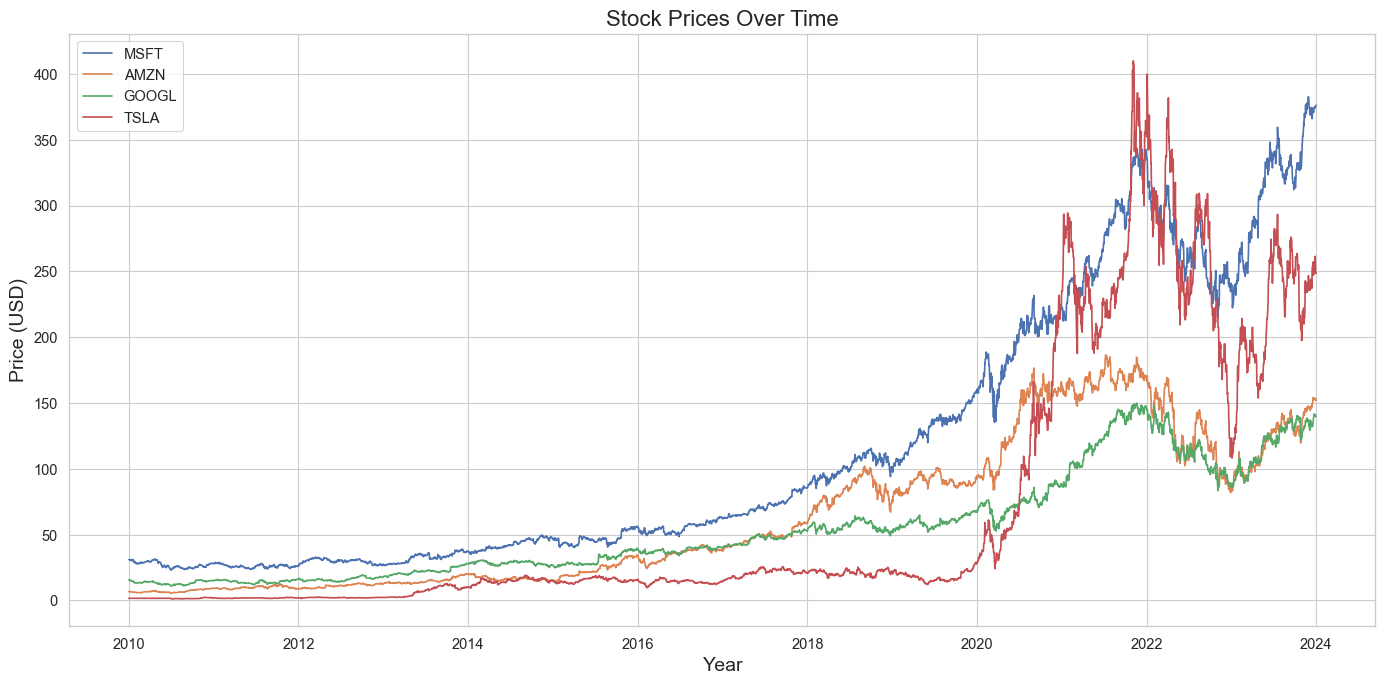

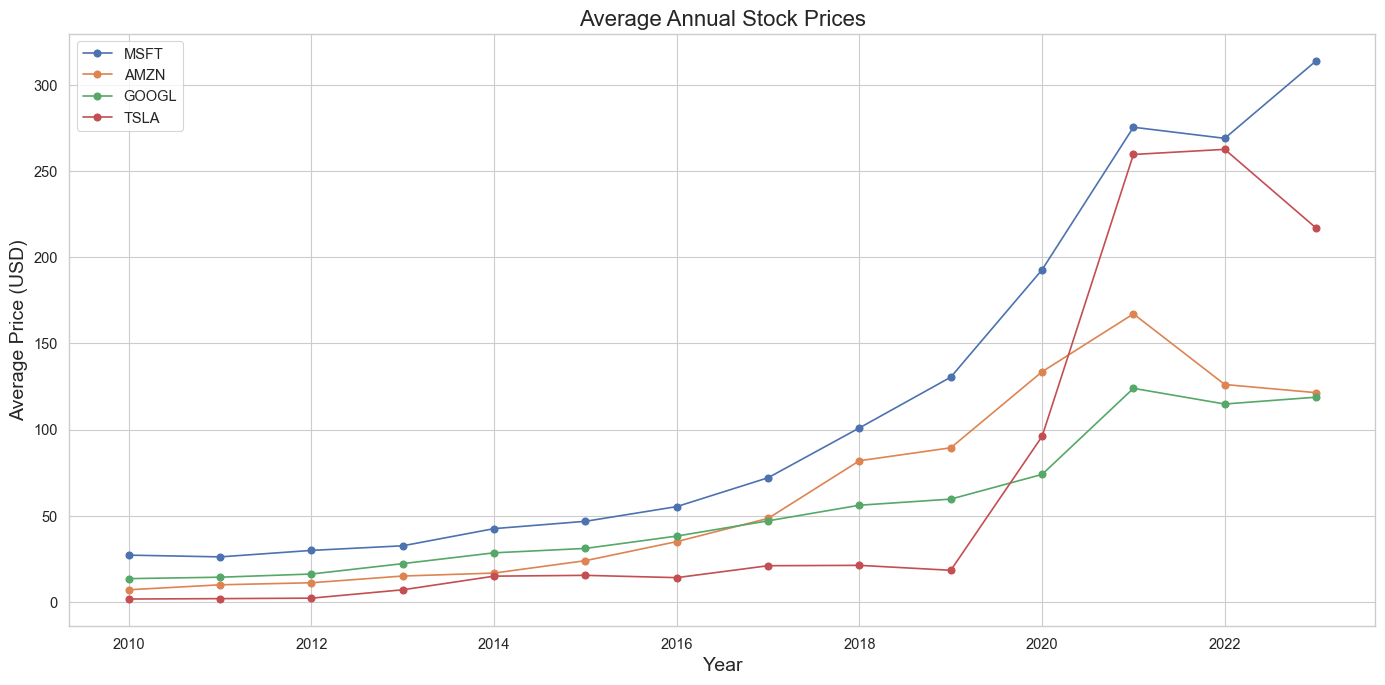

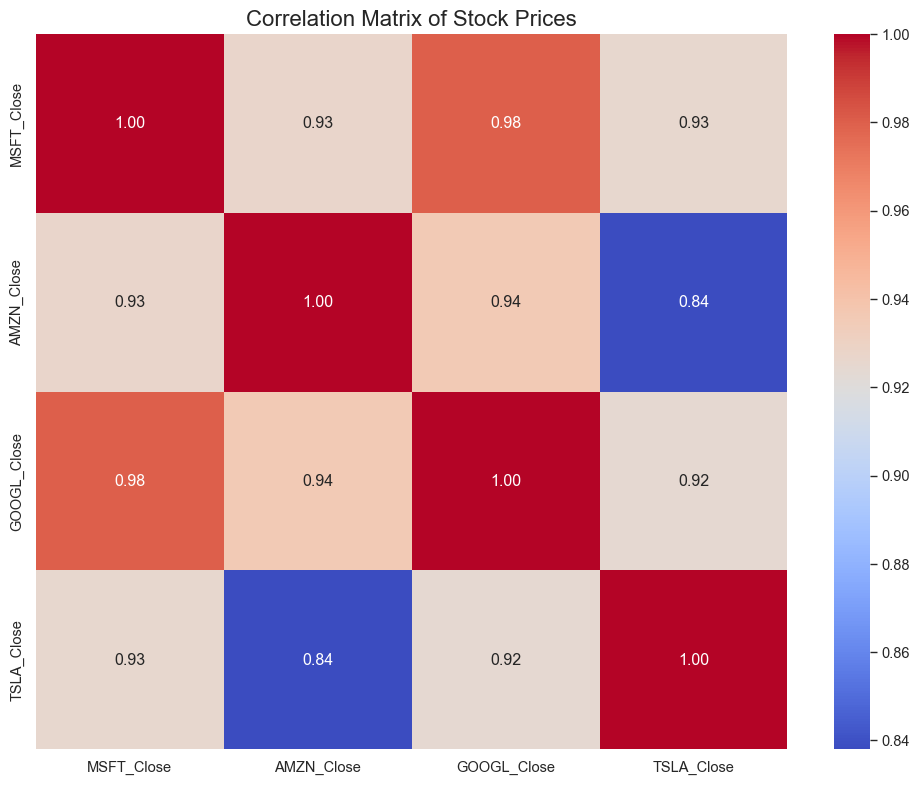


Analyzing Cryptocurrencies...


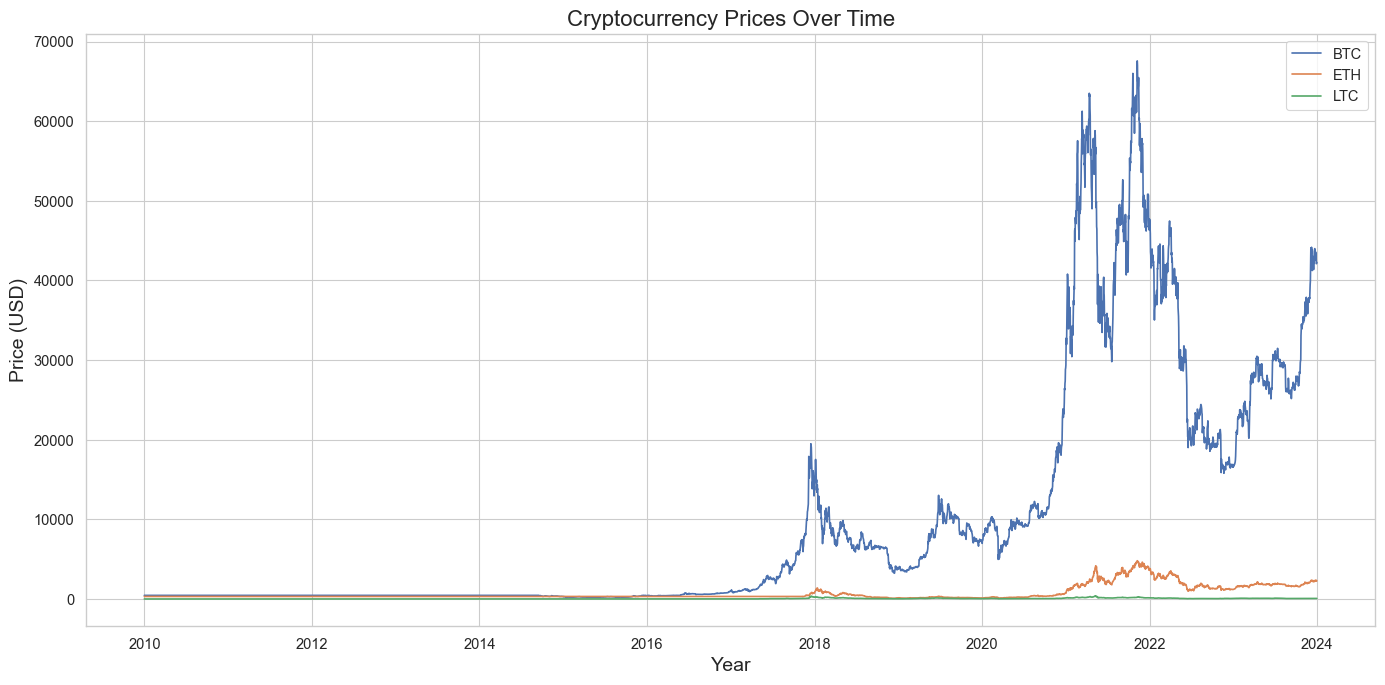

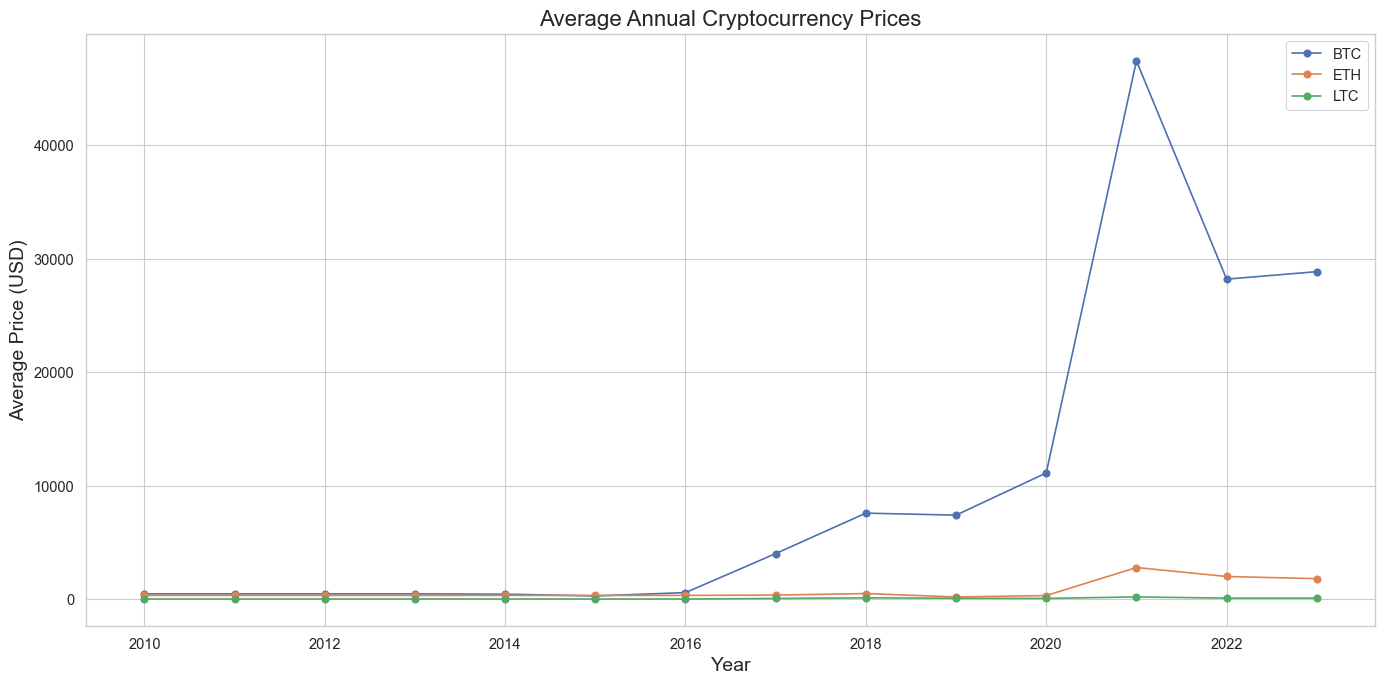

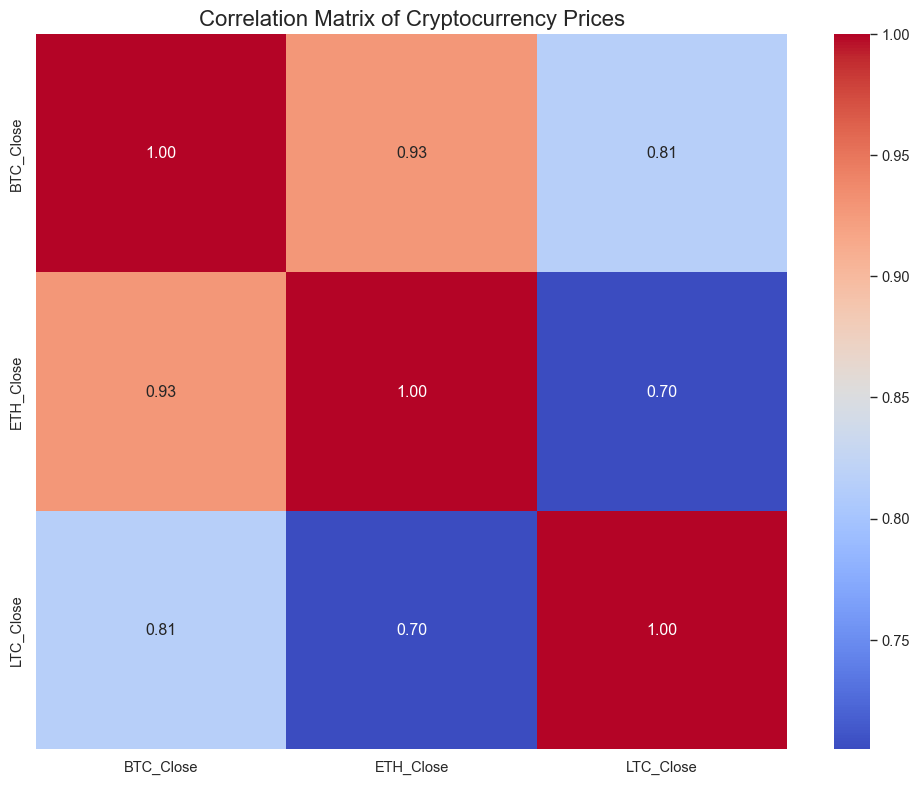


Performing Technical Analysis...


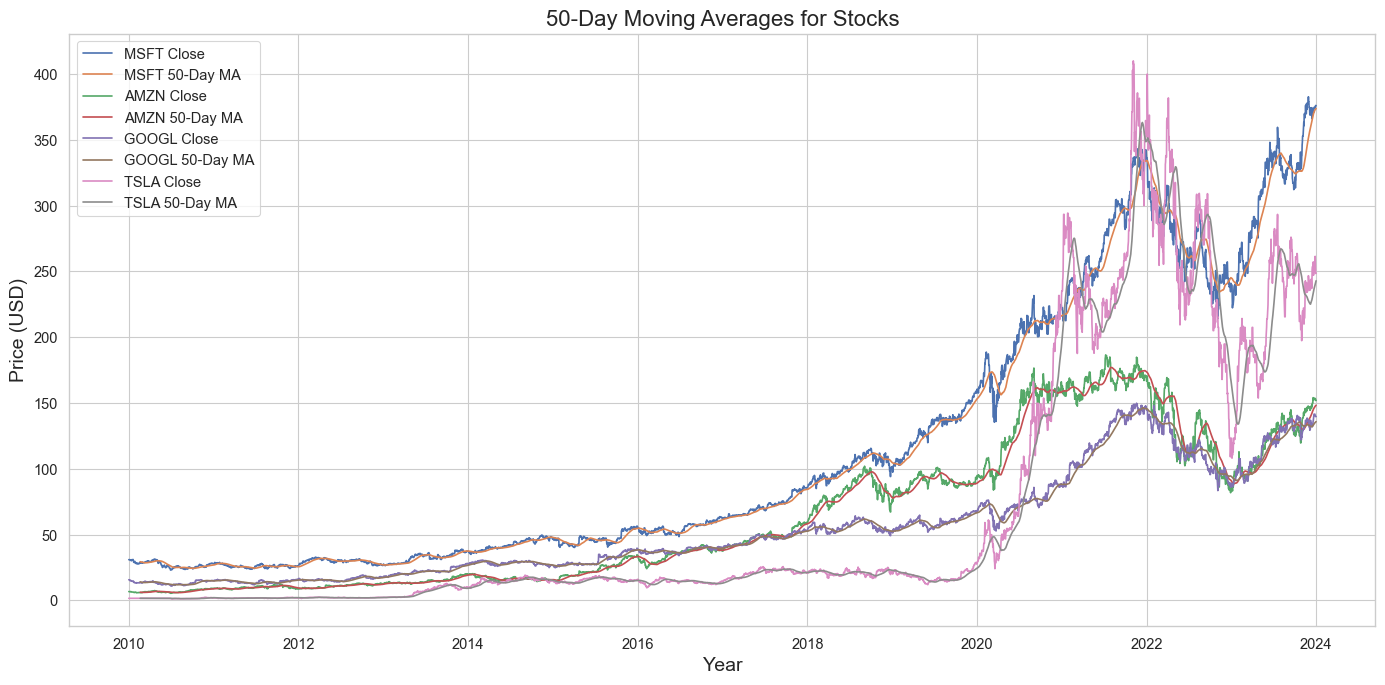


Analyzing Volatility...


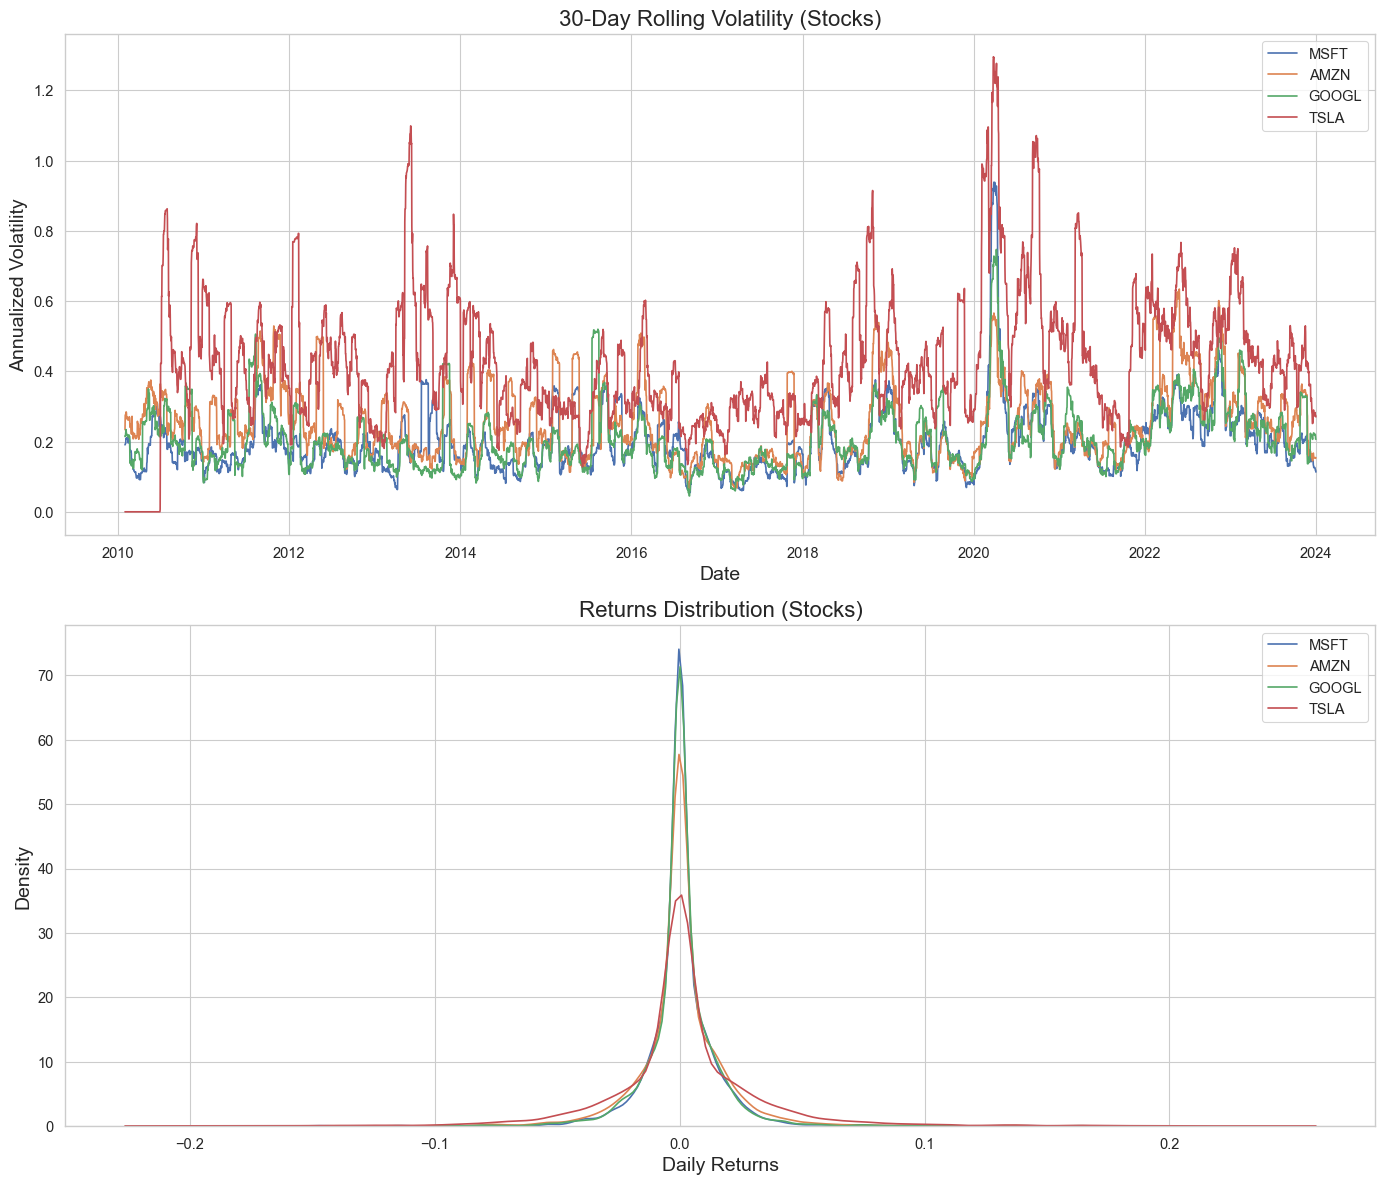

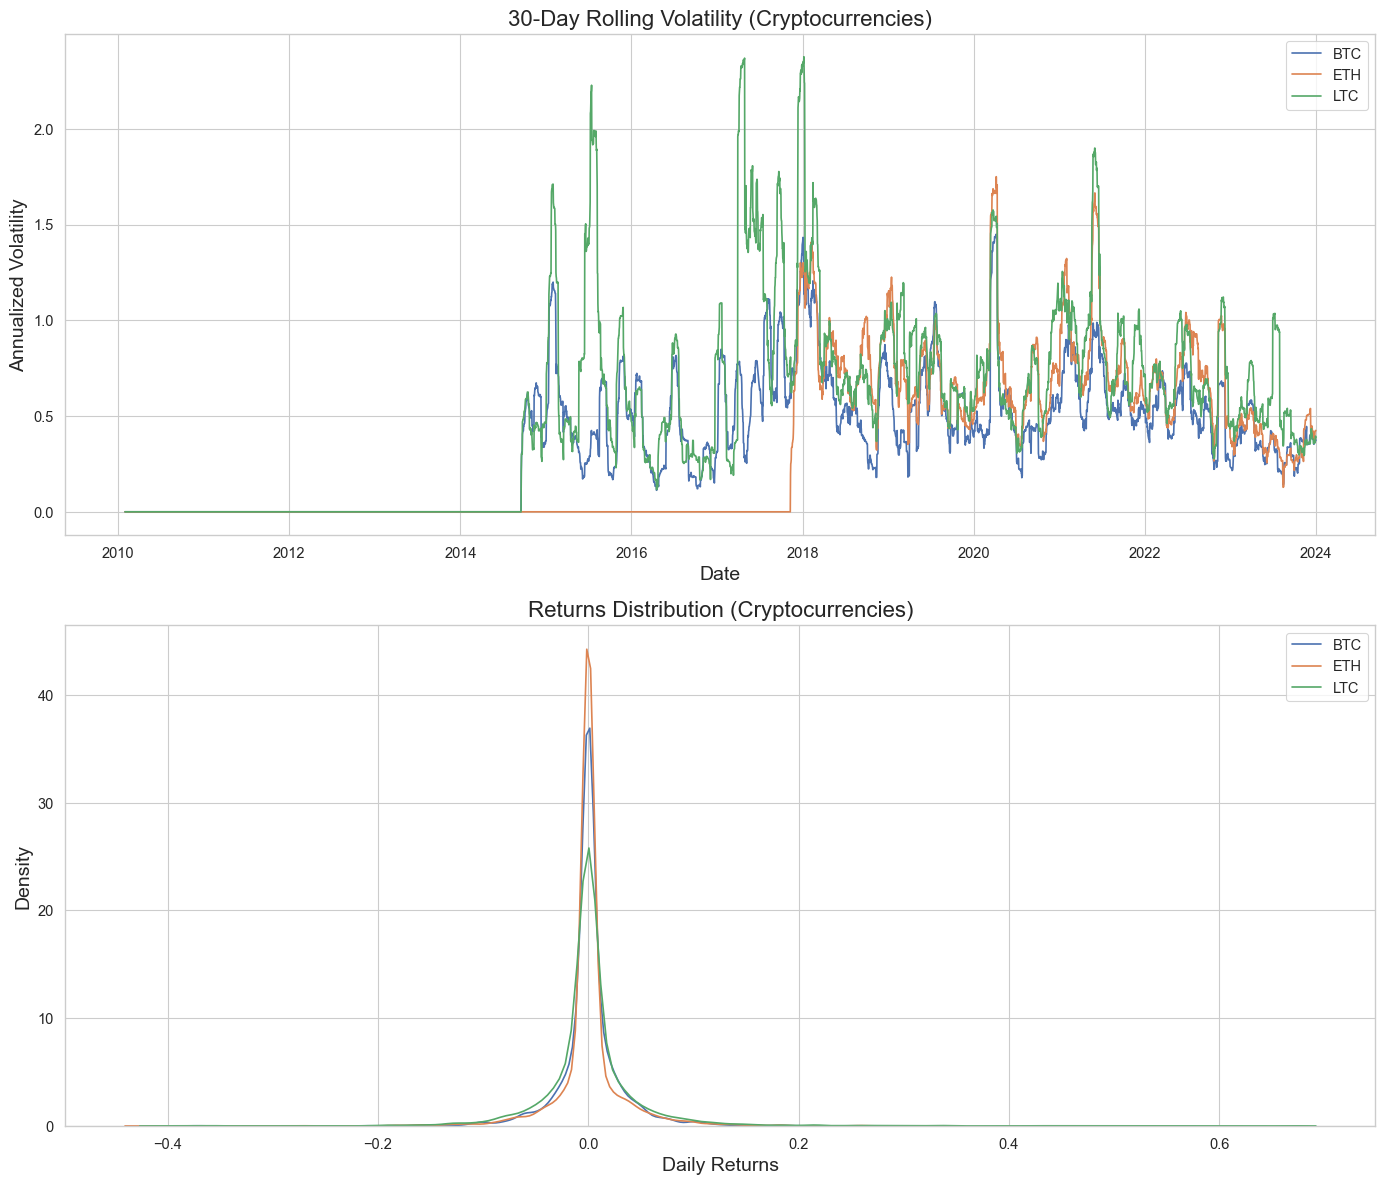


Analyzing Market Performance...


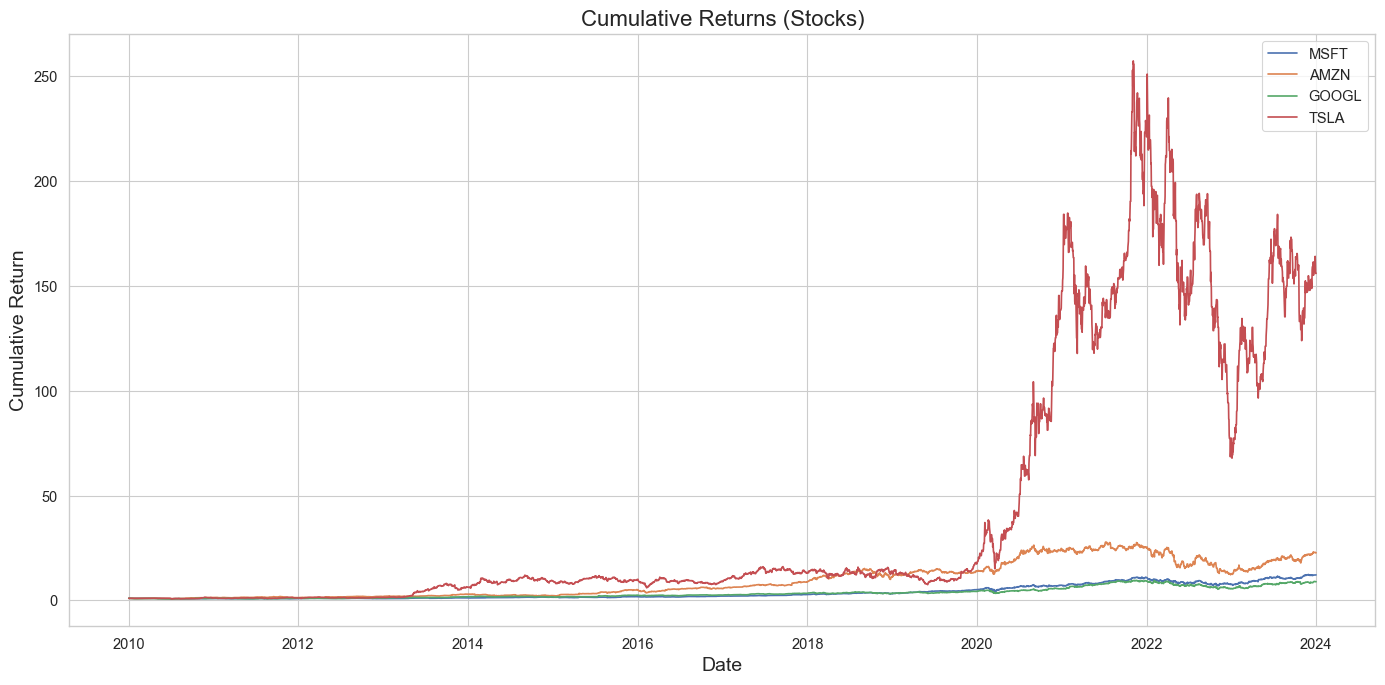

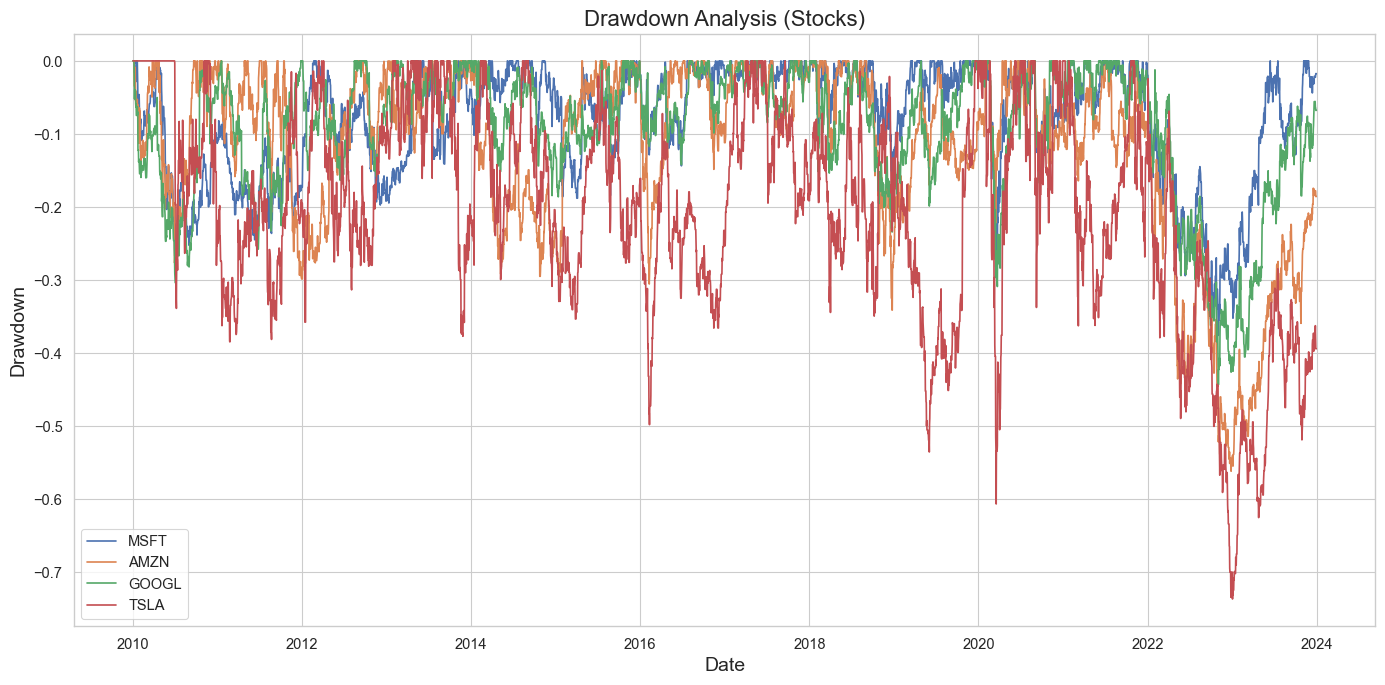


Analyzing Market Rotation...


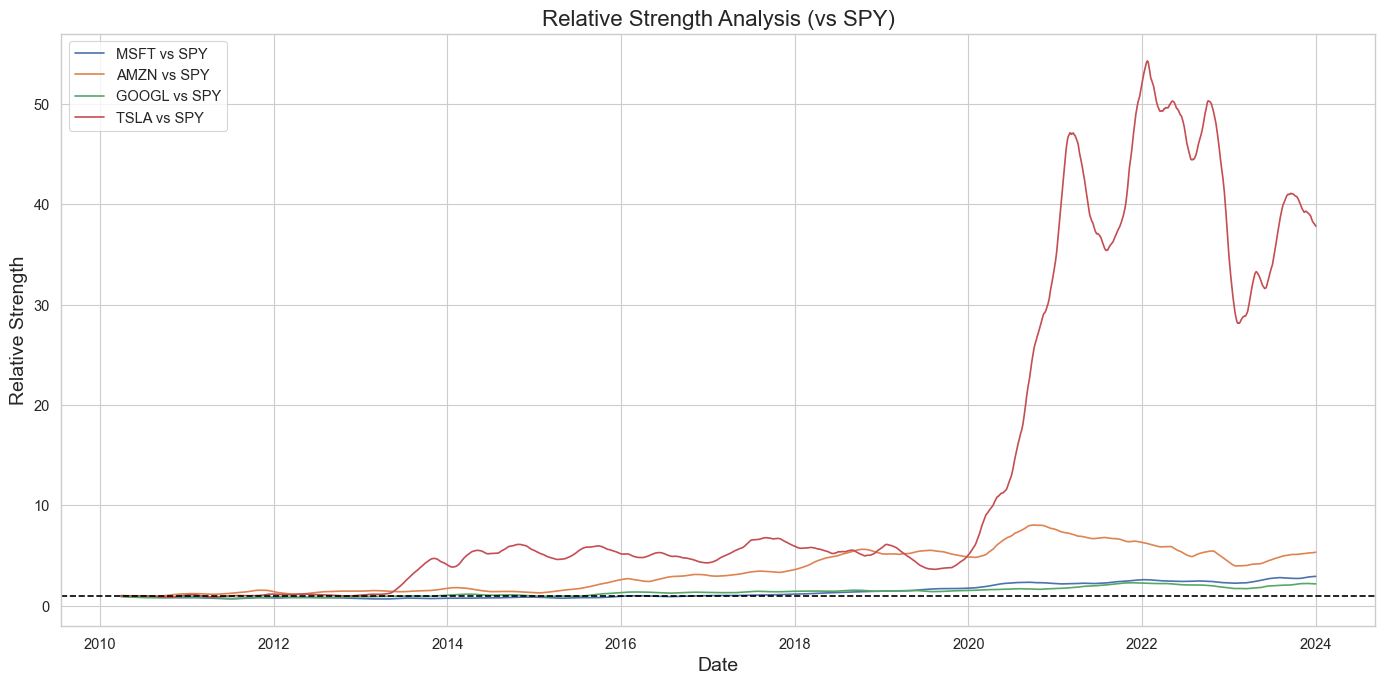


Analyzing Economic Indicators...


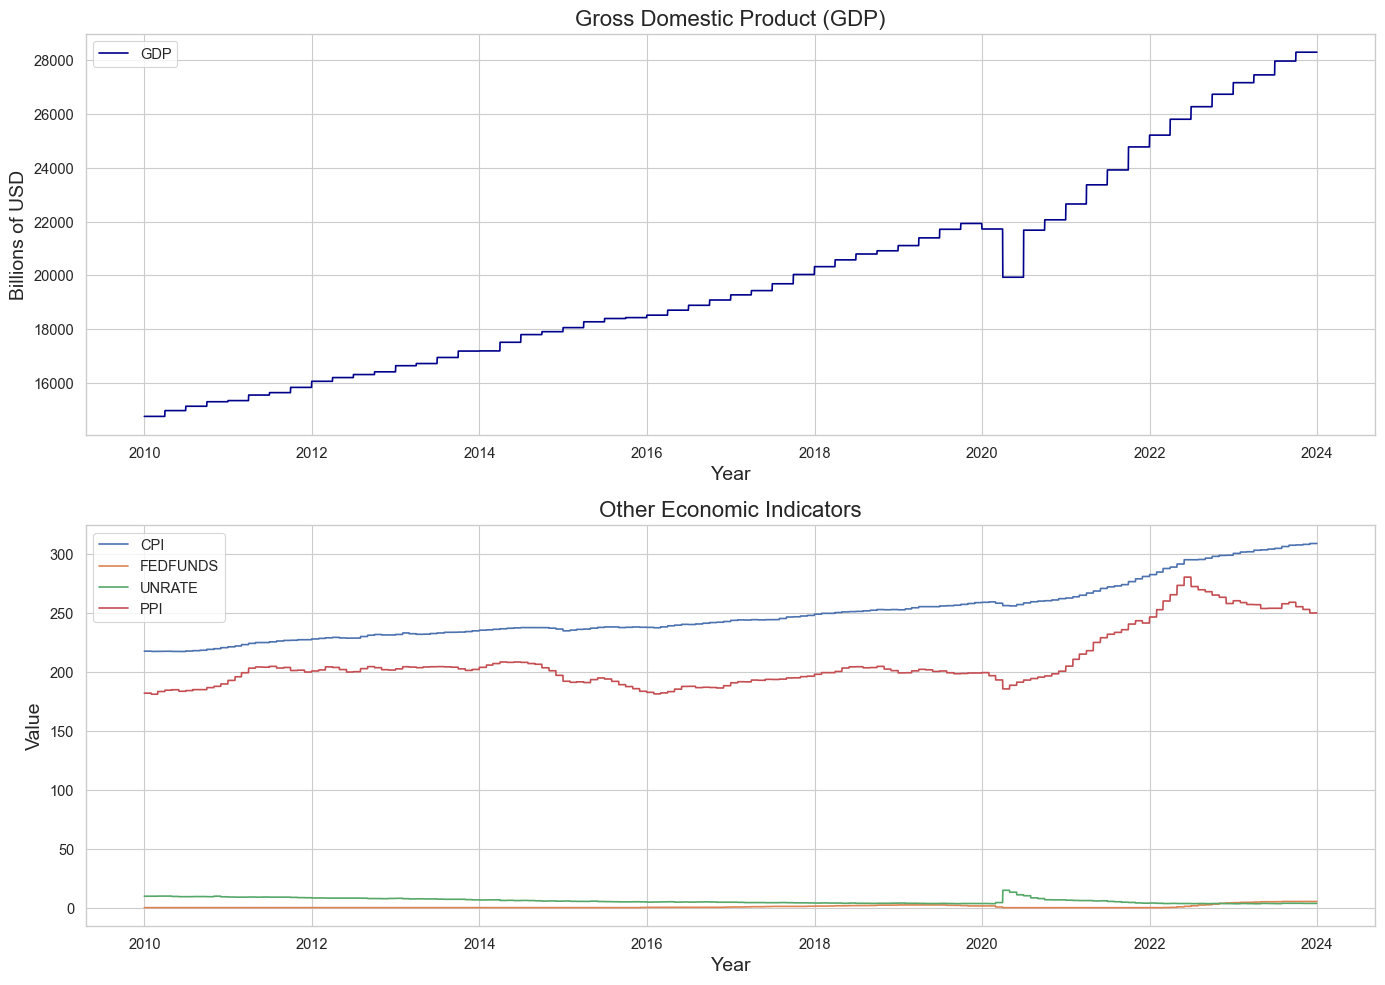

In [20]:
# Stock Analysis
print("Analyzing Stock Markets...")
plot_prices_over_time(stocks, 'Stock')
plot_annual_average(stocks, 'Stock')
plot_price_correlations(stocks, 'Stock')

# Crypto Analysis
print("\nAnalyzing Cryptocurrencies...")
plot_prices_over_time(cryptos, 'Cryptocurrency')
plot_annual_average(cryptos, 'Cryptocurrency')
plot_price_correlations(cryptos, 'Cryptocurrency')

# Technical Analysis
print("\nPerforming Technical Analysis...")
plot_moving_averages(window=50)

# Volatility Analysis
print("\nAnalyzing Volatility...")
plot_volatility_analysis(stocks, 'Stocks')
plot_volatility_analysis(cryptos, 'Cryptocurrencies')

# Performance Analysis
print("\nAnalyzing Market Performance...")
plot_cumulative_returns(stocks, 'Stocks')
plot_drawdown_analysis(stocks, 'Stocks')

# Market Rotation
print("\nAnalyzing Market Rotation...")
plot_relative_strength('SPY', stocks, window=90)  # Relative to S&P 500 ETF

# Economic Indicators
print("\nAnalyzing Economic Indicators...")
plot_economic_indicators()